In [1]:
import fsspec
from fsspec.core import url_to_fs
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/*SBE19plus*.nc')
ref_files[0:5]

['imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20130130T000612Z_NRSMAI_FV01_Profile-SBE19plus_C-20160524T001746Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170602T002825Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T024607Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170627T002425Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T025016Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170801T004358Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021501Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170922T002538Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021635Z.nc']

In [2]:
from dask.distributed import Client
client = Client(n_workers=16,threads_per_worker=16) 
client

/Users/marinelebrec/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50973 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50973/status,
Dashboard: http://127.0.0.1:50973/status,Workers: 16
Total threads: 256,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50974,Workers: 16
Dashboard: http://127.0.0.1:50973/status,Total threads: 256
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:51067,Total threads: 16
Dashboard: http://127.0.0.1:51071/status,Memory: 512.00 MiB
Nanny: tcp://127.0.0.1:50992,


In [3]:
import intake

cat =intake.open_catalog('./catalogue.yml')

In [5]:
rotto =cat.rottnest.read()

In [6]:
rotto.TIME.max()

<xarray.DataArray 'TIME' ()>
array('2021-01-21T12:00:00.000000000', dtype='datetime64[ns]')

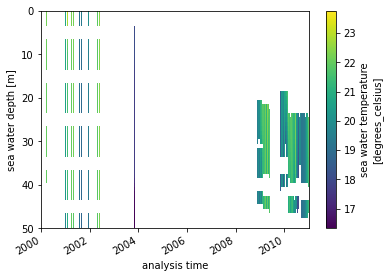

In [7]:
rotto.sel(TIME=slice("2000",'2010')).TEMP_GRID.plot(ylim=[50,0])

# Using historical surface measurements

In [10]:
surf = rotto.sel(DEPTH=slice("0"))
surf

<xarray.Dataset>
Dimensions:     (TIME: 25483, DEPTH: 1, LONGITUDE: 2, LATITUDE: 2)
Coordinates:
  * TIME        (TIME) datetime64[ns] 1951-04-17T12:00:00 ... 2021-01-21T12:0...
  * DEPTH       (DEPTH) int32 0
  * LONGITUDE   (LONGITUDE) float32 115.3 115.5
  * LATITUDE    (LATITUDE) float32 -32.08 -31.93
Data variables:
    TIME_GRID   (DEPTH, TIME) datetime64[ns] 1951-04-17T12:00:00 ... 2021-01-...
    TEMP_GRID   (DEPTH, TIME) float32 22.4 22.36 22.34 22.31 ... nan nan nan nan
    DEPTH_GRID  (DEPTH, TIME) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/35)
    date_created:                  2022-03-31T23:45:44Z
    title:                         Rottnest Island 55 m Daily 1m gridded temp...
    abstract:                      Rottnest Island 55 m Gridded Data Product:...
    Conventions:                   CF-1.6, IMOS-1.4
    acknowledgement:               Any users of IMOS data are required to cle...
    citation:                      Roughan, M. et al. Multi-decadal ocean tem...
    ...                            ...
    distribution_statement:        Data may be re-used, provided that related...
    license:                       http://creativecommons.org/licenses/by/4.0/
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    naming_authority:              IMOS
    time_coverage_start:           1951-04-17T12:00:00Z
    time_coverage_end:             2021-01-21T12:00:00Z

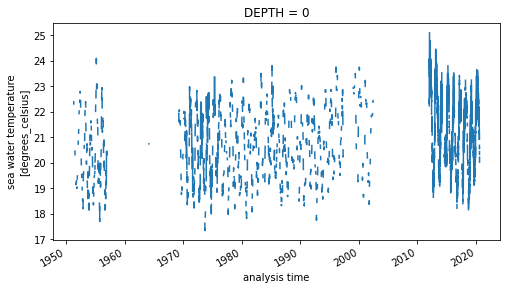

In [11]:
surf.TEMP_GRID.plot(figsize=[8,4])

There are some large gaps in the data, so we can focus on the 1975 - 2002 period when data was more abundant

In [44]:
short = surf.sel(TIME=slice("1975-01", "2000-12"))

#calculating daily, weekly, monthly, annual mean surface SST
daily_sst = short.TEMP_GRID.load().resample(TIME='1D').mean()
weekly_sst = short.TEMP_GRID.load().resample(TIME='1W').mean()
monthly_sst = short.TEMP_GRID.load().resample(TIME='1M').mean()
annual_sst = short.TEMP_GRID.load().resample(TIME='1Y').mean()

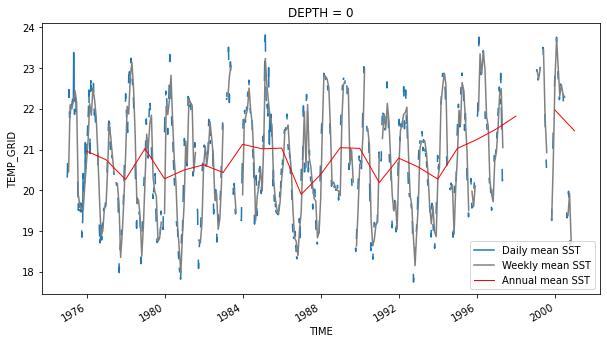

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])
daily_sst.plot(label = 'Daily mean SST')
monthly_sst.plot(label='Weekly mean SST',color='gray')
annual_sst.plot(label='Annual mean SST',color='red',lw=1)
plt.legend()

# Converting dataset to dataframe for analyses

In [55]:
import pandas as pd

df_daily = daily_sst.to_dataframe()
df_annual = annual_sst.to_dataframe()

merged_dataframe = pd.merge_asof(df_daily, df_annual, on="TIME")
merged_dataframe.head()

,TIME,TEMP_GRID_x,TEMP_GRID_y
0,1975-01-01,NaN,NaN
1,1975-01-02,NaN,NaN
2,1975-01-03,NaN,NaN
3,1975-01-04,NaN,NaN
4,1975-01-05,20.329773,NaN


In [56]:
merged_dataframe['daily'] = merged_dataframe['TEMP_GRID_x']
merged_dataframe['annual'] = merged_dataframe['TEMP_GRID_y']

In [57]:
merged_dataframe = merged_dataframe.drop(['TEMP_GRID_x','TEMP_GRID_y'], axis=1)
merged_dataframe.head()

,TIME,daily,annual
0,1975-01-01,NaN,NaN
1,1975-01-02,NaN,NaN
2,1975-01-03,NaN,NaN
3,1975-01-04,NaN,NaN
4,1975-01-05,20.329773,NaN


In [58]:
merged_dataframe['anomaly'] = merged_dataframe['daily'] - merged_dataframe['annual']

Text(0, 0.5, 'anomaly (degC)')

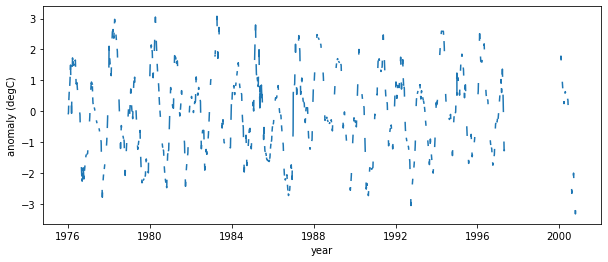

In [60]:
plt.figure(figsize=[10,4])
plt.plot(merged_dataframe['TIME'],merged_dataframe['anomaly'])
plt.xlabel('year')
plt.ylabel('anomaly (degC)')

In [8]:
import s3fs
import xarray as xr
from dask import bag as db

def open_cdt(url):
    s3 = s3fs.S3FileSystem(anon=True,default_fill_cache=False,default_cache_type=None)
    with s3.open(url,) as f:
        data=xr.open_dataset(f,engine='h5netcdf').load().squeeze()
        data['TEMP'] = data['TEMP']#[data.TEMP_quality_control==1]
    return data


b = db.from_sequence(ref_files)
cast = db.map(open_cdt,b).compute()

2022-08-17 13:30:09,579 - distributed.worker - WARNING - Compute Failed
Key:       ('open_cdt-35d3f07dfbce14d1c4eafed7b40e018c', 29)
Function:  execute_task
args:      ((<function reify at 0x7fe2f3703040>, (<function map_chunk at 0x7fe2f3703430>, <function open_cdt at 0x7fe2f36601f0>, [['imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20200629T004444Z_NRSMAI_FV01_Profile-SBE19plus_C-20200701T043509Z.nc']], None, {})))
kwargs:    {}
Exception: 'ValueError("unrecognized engine h5netcdf must be one of: [\'netcdf4\', \'scipy\', \'store\', \'zarr\']")'

2022-08-17 13:30:09,579 - distributed.worker - WARNING - Compute Failed
Key:       ('open_cdt-35d3f07dfbce14d1c4eafed7b40e018c', 14)
Function:  execute_task
args:      ((<function reify at 0x7fe2f3703040>, (<function map_chunk at 0x7fe2f3703430>, <function open_cdt at 0x7fe2f36604c0>, [['imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20180711T234932Z_NRSMAI_FV01_Profile-SBE19plus_C-20180

ValueError: unrecognized engine h5netcdf must be one of: ['netcdf4', 'scipy', 'store', 'zarr']

In [ ]:
commonvars = list(set.intersection(*list((map(lambda x:set([i for i in x.data_vars]),cast)))))
cast = [ds[commonvars] for ds in cast]

In [ ]:
c =xr.concat(cast,dim='TIME')
c.isel(TIME=1).DEPTH